In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))
from backtracking import resolver
from greedy_pakku import greedy_pakku
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def generar_habilidades(n):
    habilidades = []
    for _ in range(n):
        habilidades.append(random.randint(10, 1000))
    return habilidades

### Parámetros

In [25]:
SEED = 67910

In [26]:
random.seed(SEED)

In [27]:

def experimentar(k, ns, repeticiones=10):
    """
    Ejecuta experimentos comparando greedy pakku vs backtracking óptimo.
    Devuelve un DataFrame con TODAS las ejecuciones individuales.
    
    Columnas:
      n: tamaño del conjunto
      trial: número de repetición
      greedy_val: valor obtenido por el greedy
      opt_val: valor óptimo (o None si timeout)
      ratio: greedy_val / opt_val
      greedy_time: tiempo ejecución greedy (s)
      opt_time: tiempo ejecución backtracking (s)
    """
    registros = []
    
    for n in ns:
        for t in range(repeticiones):
            habilidades = generar_habilidades(n)

            # --- Greedy ---
            start = time.perf_counter()
            greedy_val, _ = greedy_pakku(k, habilidades)
            greedy_time = time.perf_counter() - start

            # --- Backtracking óptimo ---
            start = time.perf_counter()
            opt_val, opt_part = resolver(k, habilidades)
            opt_time = time.perf_counter() - start

            ratio = greedy_val / opt_val

            registros.append({
                "n": n,
                "trial": t,
                "greedy_val": greedy_val,
                "opt_val": opt_val,
                "ratio": ratio,
                "greedy_time": greedy_time,
                "opt_time": opt_time,
            })

    df = pd.DataFrame(registros)
    return df


In [28]:


# --- Boxplot de ratios ---
def plot_boxplot_ratios(df, k, save_path=None):
    df_ok = df.copy()

    grouped = [group["ratio"].values for _, group in df_ok.groupby("n")]
    labels = [str(name) for name, _ in df_ok.groupby("n")]

    plt.figure(figsize=(8, 5))
    plt.boxplot(grouped, labels=labels)
    plt.xlabel("Tamaño (n)")
    plt.ylabel("Ratio greedy / óptimo")
    plt.title(f"Distribución de ratios — k={k}")
    plt.grid(True, linestyle="--", alpha=0.6)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.show()


In [29]:
# --- Curva de peor, media y mediana del ratio ---
def plot_worst_vs_n(df, k, save_path=None):
    df_ok = df.copy()


    stats = (
        df_ok.groupby("n")["ratio"]
        .agg(["min", "median", "mean", "max"])
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    plt.plot(stats["n"], stats["max"], marker="o", label="Peor caso (máx)")
    plt.plot(stats["n"], stats["mean"], marker="x", label="Media")
    plt.plot(stats["n"], stats["median"], marker="s", label="Mediana")
    plt.xlabel("Tamaño (n)")
    plt.ylabel("Ratio greedy / óptimo")
    plt.title(f"Comparación de ratios por tamaño — k={k}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.show()

In [30]:
def plot_summary_threepanels(df, k, figsize=(8, 14), save_path=None):
    """
    Dibuja en una sola figura vertical:
      (1) boxplot de ratios greedy/óptimo por n,
      (2) curva con peor/media/mediana del ratio por n,
      (3) diferencia absoluta (greedy - opt) por n (media + rango).
    df debe tener columnas: ['n','trial','greedy_val','opt_val','ratio','timed_out'].
    """
    df_ok = df.copy()
    
    # stats agregadas por n
    stats_ratio = df_ok.groupby("n")["ratio"].agg(["min","median","mean","max"]).reset_index()
    df_ok["diff_abs"] = df_ok["greedy_val"] - df_ok["opt_val"]
    stats_diff = df_ok.groupby("n")["diff_abs"].agg(["min","median","mean","max"]).reset_index()

    ns = sorted(df_ok["n"].unique())
    labels = [str(n) for n in ns]

    fig, axes = plt.subplots(3, 1, figsize=figsize, constrained_layout=True)

    # 1) Boxplot ratios (arriba)
    grouped = [group["ratio"].values for _, group in df_ok.groupby("n")]
    axes[0].boxplot(grouped, labels=labels)
    axes[0].set_xlabel("")  # sólo eje inferior tendrá label
    axes[0].set_ylabel("Ratio greedy / óptimo")
    axes[0].set_title(f"(1) Distribución de ratios — k={k}")
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # 2) Peor/Media/Mediana del ratio (medio)
    axes[1].plot(stats_ratio["n"], stats_ratio["max"], marker="o", label="max")
    axes[1].plot(stats_ratio["n"], stats_ratio["mean"], marker="x", label="mean")
    axes[1].plot(stats_ratio["n"], stats_ratio["median"], marker="s", label="median")
    axes[1].set_xlabel("Tamaño (n)")
    axes[1].set_ylabel("Ratio greedy / óptimo")
    axes[1].set_title(f"(2) Peor / Media / Mediana del ratio por n — k={k}")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    # 3) Diferencia absoluta (abajo)
    axes[2].plot(stats_diff["n"], stats_diff["mean"], marker="o", label="mean")
    axes[2].plot(stats_diff["n"], stats_diff["median"], marker="s", label="median")
    axes[2].fill_between(stats_diff["n"], stats_diff["min"], stats_diff["max"], alpha=0.2, label="range")
    axes[2].set_xlabel("Tamaño (n)")
    axes[2].set_ylabel("Diferencia absoluta")
    axes[2].set_title(f"(3) Diferencia absoluta (greedy - óptimo) — k={k}")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.5)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.show()


In [31]:
ns = [6, 9, 12, 15, 18]
k = 3
df = experimentar(k=k, ns=ns, repeticiones=10)

C:\Users\Hugo\AppData\Local\Temp\ipykernel_6292\3368974473.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=labels)


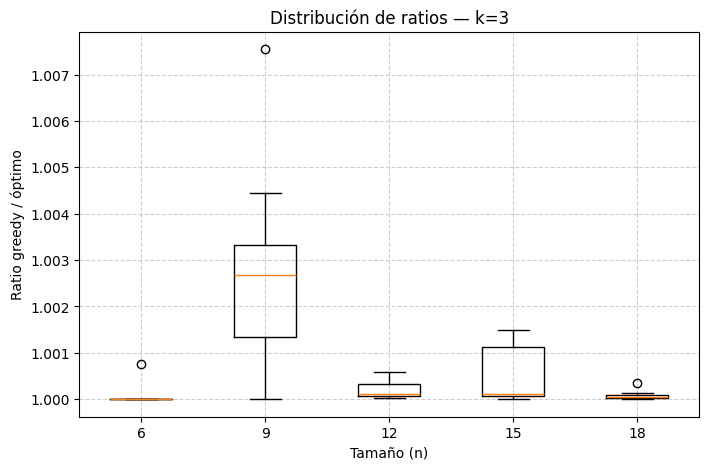

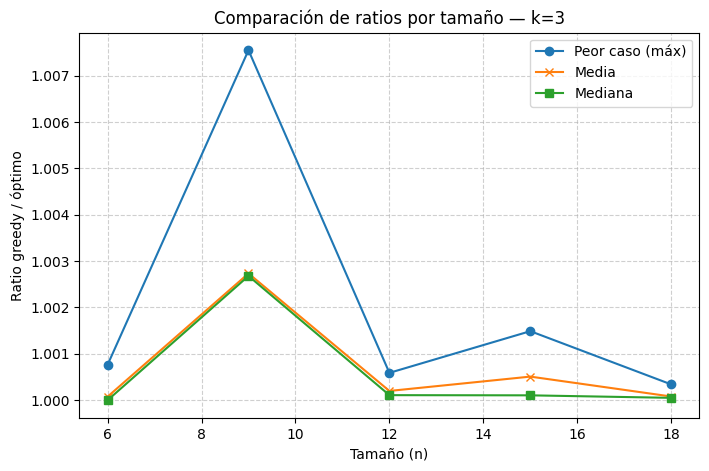

In [32]:
plot_boxplot_ratios(df, k=k, )
plot_worst_vs_n(df, k=k)

C:\Users\Hugo\AppData\Local\Temp\ipykernel_6292\1777763701.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(grouped, labels=labels)


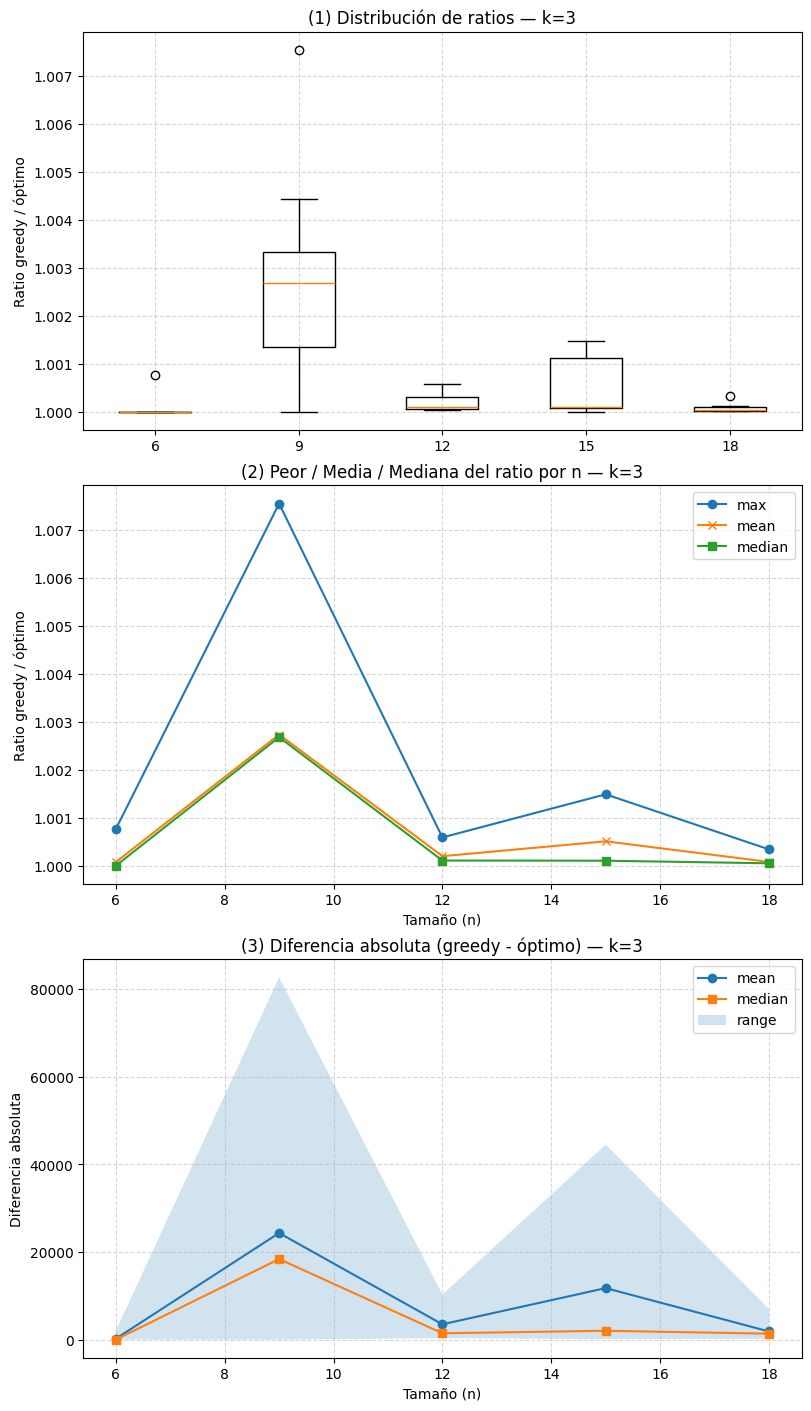

In [33]:


# Mostrar resumen general
df.groupby("n")["ratio"].agg(["mean","median","max"])

# Graficar comparación
plot_summary_threepanels(df, k=k, figsize=(8,14), save_path="../informe/img/pakku_vs_bt.png")
